In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Tuple, Optional
import os
import os.path as osp
from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
import sklearn, statsmodels
import numpy as np
import warnings


class SDF:
    def __init__(
        self,
        df: pd.DataFrame,
        label_cols: List[str],
        feature_cols: List[str] = None,
        plot_folder: str = "",
        plot_format: str = "png",
        feature_descriptions: Optional[Dict[str, str]] = None,
    ):

        '''
        Initialize the SDF object
        df: pandas dataframe
        label_cols: list of column names of the labels
        feature_cols: list of column names of the features
        plot_folder: folder to save plots
        plot_format: format of the plots
        feature_descriptions: dictionary of feature descriptions
        '''

        self.df = df

        self.label_cols = label_cols
        self.labels = self.df[label_cols]

        if feature_cols is None:
            self.feature_cols = self.df.columns.drop(label_cols)
            self.features = self.df.drop(label_cols, axis=1)
        else:
            self.feature_cols = feature_cols
            self.features = self.df[feature_cols]

        self.plot_folder = plot_folder
        self.plot_format = plot_format
        self.feature_descriptions = feature_descriptions

        if self.feature_descriptions is not None:
            self.print_feature_descriptions()

        if self.plot_folder == "":
            self.plot_folder = "./plots/"
            self.safe_mkdir(self.plot_folder)

        self.label_column = self.df.columns[-1]

    def safe_mkdir(self, path):
        '''
        Create a directory if it does not exist
        '''
        if not osp.exists(path):
            os.makedirs(path)

    def print_feature_descriptions(
        self,
    ):
        '''
        Print the feature and label descriptions
        '''

        print("The features are ")
        for feature in self.feature_cols:
            print(feature + ": " + self.feature_descriptions[feature])

        print("====================================")
        
        print("The labels are ")
        for label in self.label_cols:
            print(label + ": " + self.feature_descriptions[label])
            

    def savefig_or_show(
        self,
        filename: str = None,
    ):
        '''
        Save the figure or show it
        '''
        if filename is not None:
            plt.savefig(osp.join(self.plot_folder, filename), format=self.plot_format)
            plt.clf()
        else:
            plt.show()

    def get_model_statistics(
        self,
        model,
        features: pd.DataFrame = None,
        label: str = None,
    ):

        '''
        Get the model statistics
        model: linear model
        '''

        is_statsmodels = False
        is_sklearn = False
        has_intercept = False
        X = features

        if label is None:
            y = self.labels[self.label_cols[0]]
        else:
            y = self.labels[label]

        y = list(y)

        # check for accepted linear models
        if type(model) in [
            sklearn.linear_model._base.LinearRegression,
            sklearn.linear_model._ridge.Ridge,
            sklearn.linear_model._ridge.RidgeCV,
            sklearn.linear_model._coordinate_descent.Lasso,
            sklearn.linear_model._coordinate_descent.LassoCV,
            sklearn.linear_model._coordinate_descent.ElasticNet,
            sklearn.linear_model._coordinate_descent.ElasticNetCV,
            sklearn.linear_model.HuberRegressor,
        ]:
            is_sklearn = True
        elif type(model) in [
            statsmodels.regression.linear_model.OLS,
            statsmodels.base.elastic_net.RegularizedResults,
        ]:
            is_statsmodels = True
        else:
            print("Only linear models are supported!")
            return None

        if is_statsmodels and all(np.array(X)[:, 0] == 1):
            has_intercept = True
        elif is_sklearn and model.intercept_:
            has_intercept = True

        if is_statsmodels:
            x = X
            model_params = model.params
        else:
            if has_intercept:
                x = sm.add_constant(X)
                model_params = np.hstack([np.array([model.intercept_]), model.coef_])
            else:
                x = X
                model_params = model.coef_

        olsModel = sm.OLS(y, x)
        pinv_wexog, _ = pinv_extended(x)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        return sm.regression.linear_model.OLSResults(
            olsModel, model_params, normalized_cov_params
        )

    def get_correlations(self):
        '''
        Get the correlations
        '''
        
        cr = self.df.corr()[self.label_cols]
        cr = cr.drop(self.label_cols, axis=0)
        sns.heatmap(
            cr,
            annot=True
        )
        self.savefig_or_show()

    def two_dimensions_plot(
        self,
        plot_func,  
        xsplit_col: str,
        ysplit_col: str,
        xsplit_subset: List[str] = None,
        ysplit_subset: List[str] = None,
        title: str = "",
    ):

        # get the unique values of the split columns
        xsplit_vals = self.df[xsplit_col].unique()
        ysplit_vals = self.df[ysplit_col].unique()

        # take the subset of the unique values if specified
        if xsplit_subset is not None:
            xsplit_vals = xsplit_subset
        if ysplit_subset is not None:
            ysplit_vals = ysplit_subset

        # sort the unique values
        xsplit_vals.sort()
        ysplit_vals.sort()

        # set the plot size
        fig, axes = plt.subplots(len(xsplit_vals), len(ysplit_vals), figsize=(5 * len(xsplit_vals), 5 * len(ysplit_vals)))
        if title != "":
            fig.suptitle(title)
        else:
            fig.suptitle("Splitting by " + xsplit_col + " and " + ysplit_col)

        # Iterate over the unique values of the split columns
        for i, xsplit_val in enumerate(xsplit_vals):
            for j, ysplit_val in enumerate(ysplit_vals):
                # select the data with the unique values of the split columns
                df = self.df[
                    (self.df[xsplit_col] == xsplit_val)
                    & (self.df[ysplit_col] == ysplit_val)
                ]
                # plot the data
                ax = axes[i, j]
                plot_func(df, ax, self)
                ax.set_title(xsplit_col + ": " + str(xsplit_val) + ", " + ysplit_col + ": " + str(ysplit_val))

        plt.show()


The features are 
bill_length_mm: Bill length in mm
bill_depth_mm: Bill depth in mm
flipper_length_mm: Flipper length in mm
The labels are 
body_mass_g: Body mass in g
body_mass_kg: Body mass in kg


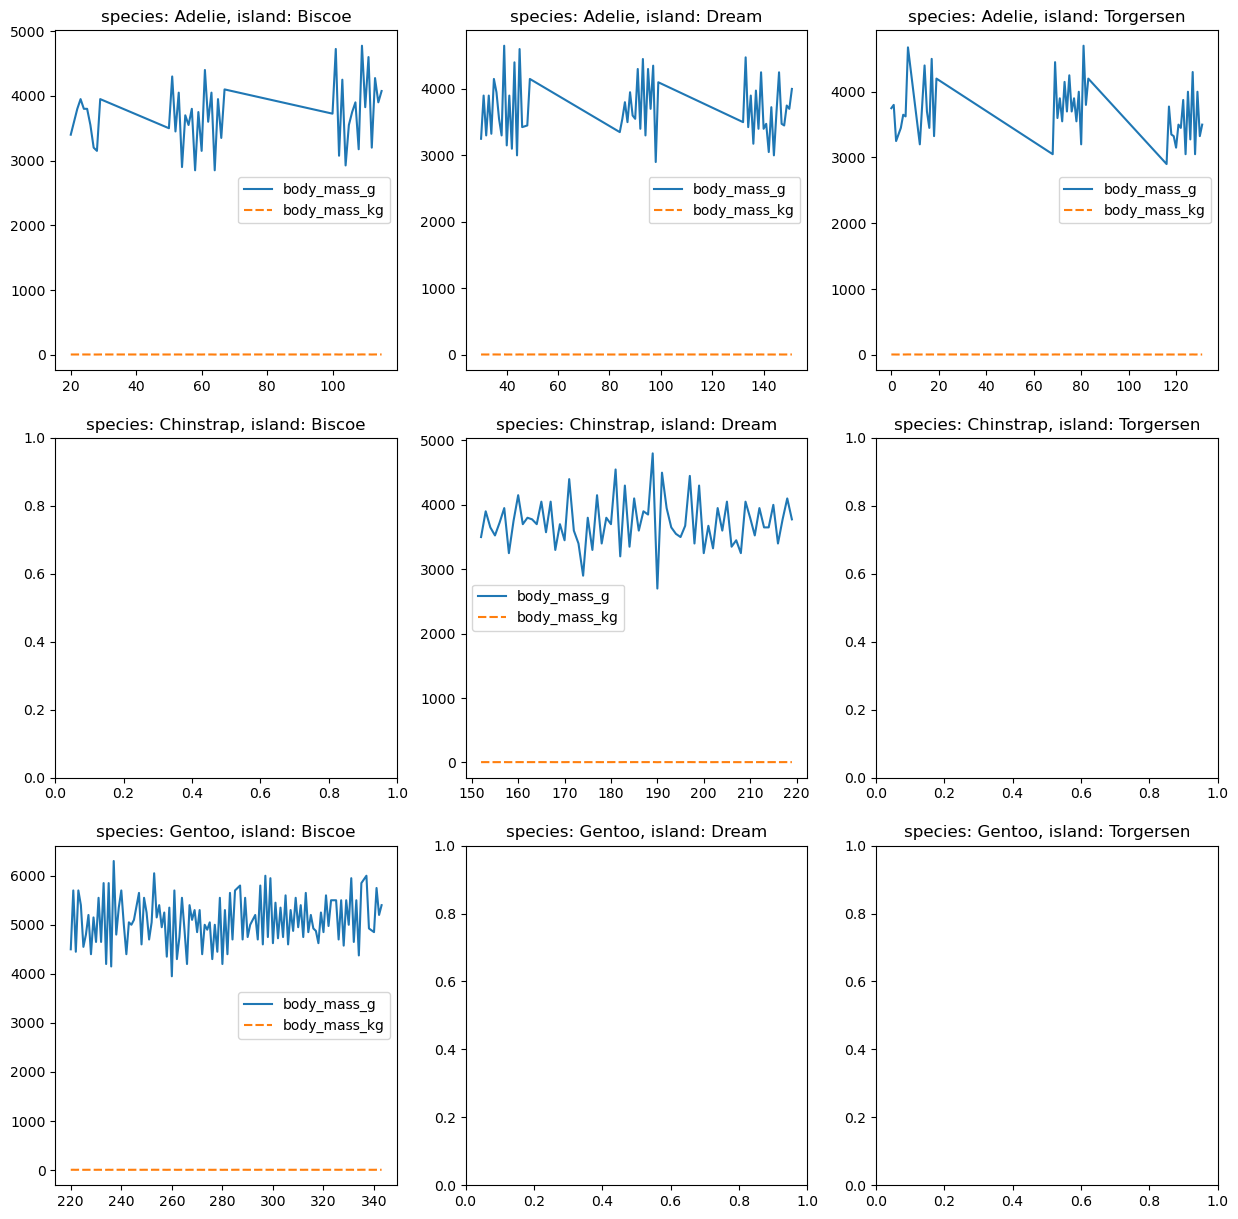

In [177]:
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins['body_mass_kg'] = penguins['body_mass_g'] / 1000
sd = SDF(
    penguins,
    feature_cols=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"],
    label_cols=["body_mass_g", "body_mass_kg"],
    feature_descriptions={
        "bill_length_mm": "Bill length in mm",
        "bill_depth_mm": "Bill depth in mm",
        "flipper_length_mm": "Flipper length in mm",
        "body_mass_g": "Body mass in g",
        "body_mass_kg": "Body mass in kg",
    }
)

# sd.get_correlations()
sd.two_dimensions_plot(
    plot_func= lambda df, ax, sd: sns.lineplot(data=df[["body_mass_g", "body_mass_kg"]], ax=ax),
    xsplit_col="species",
    ysplit_col="island",
)

In [138]:
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins['body_mass_kg'] = penguins['body_mass_g'] / 1000
enr = ElasticNetRegressor(
    penguins,
    feature_cols=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"],
    label_cols=["body_mass_g", "body_mass_kg"],
    feature_descriptions={
        "bill_length_mm": "Bill length in mm",
        "bill_depth_mm": "Bill depth in mm",
        "flipper_length_mm": "Flipper length in mm",
        "body_mass_g": "Body mass in g",
        "body_mass_kg": "Body mass in kg",
    }
)

enr.train(verbose_level=2, label_col="body_mass_kg")
predictions = enr.predict(enr)
print(sklearn.metrics.r2_score(enr.labels['body_mass_kg'], predictions))

The features are 
bill_length_mm: Bill length in mm
bill_depth_mm: Bill depth in mm
flipper_length_mm: Flipper length in mm
The labels are 
body_mass_g: Body mass in g
body_mass_kg: Body mass in kg
Training the model...
We are using the following features
Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'], dtype='object')
to predict
body_mass_kg
The training R2 score is  0.763929214502808
(333, 3)
(333, 3)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     354.9
Date:                Mon, 03 Jul 2023   Prob (F-statistic):          9.31e-103
Time:                        15:34:42   Log-Likelihood:                -159.50
No. Observations:                 333   AIC:                             327.0
Df Residuals:            

/Users/arnhavdatar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/arnhavdatar/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [135]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,body_mass_kg
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,4.207057
std,5.468668,1.969235,14.015765,805.215802,0.805216
min,32.100000,13.100000,172.000000,2700.000000,2.700000
25%,39.500000,15.600000,190.000000,3550.000000,3.550000
50%,44.500000,17.300000,197.000000,4050.000000,4.050000
75%,48.600000,18.700000,213.000000,4775.000000,4.775000
max,59.600000,21.500000,231.000000,6300.000000,6.300000


In [140]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,body_mass_kg
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,3.750
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,3.800
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,3.250
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,3.450
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,3.650
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,4.925
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,4.850
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,5.750
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,5.200


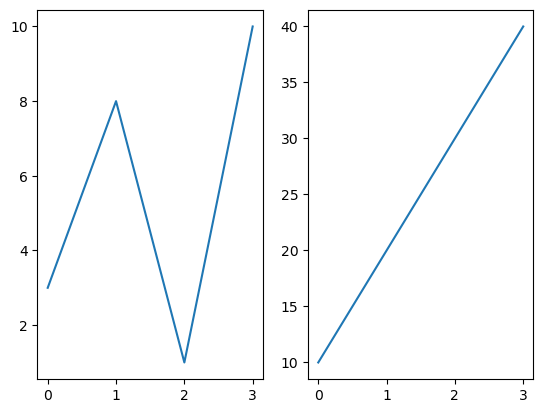

In [158]:
x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(1, 2, 1)
plt.plot(x,y)

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 2, 2)
plt.plot(x,y)

plt.show()